In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import seed
import tensorflow as tf
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras import optimizers
from keras import backend
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import time
import math
from sklearn import cluster,datasets,metrics
from sklearn.decomposition import PCA
import sys
import time

Using TensorFlow backend.


In [2]:
def PlotScatter(var,t):
    data = pd.concat((train_df[TargetIndex[t]], train_df[var]),axis=1)  
    f, ax = plt.subplots(figsize=(16, 8))
    fig = plt.scatter(x=var, y=TargetIndex[t], data=data)
def PlotBox(var,t):
    data = pd.concat((train_df[TargetIndex[t]], train_df[var]),axis=1)  
#     f, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(x=var, y=TargetIndex[t], data=data,whis=1)
#     fig.axis(ymin=0, ymax=0.01)
def History(hist):
    plt.plot(hist.history["mae"])
    plt.plot(hist.history["val_mae"])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

In [3]:
TargetIndex = ["CIEX","CIEY","CIEX_DIFF","CIEY_DIFF"]
Dp = ['id','5-1_value','5-2_value','5-3_value']
Label_Index = ['PLC_THICKNESS_SP','XXXX_USE_TIME_2','PLC_THICKNESS_2','THICKNESS_3','STATE_3','XXXX_RATE_3','XXXX_POWER_3','MASK_CHANGE_COUNT_PV']
Label_Index_PID = ['P_ID','PLC_THICKNESS_SP','XXXX_USE_TIME_2','PLC_THICKNESS_2','THICKNESS_3','STATE_3','XXXX_RATE_3','XXXX_POWER_3','MASK_CHANGE_COUNT_PV']
Columns = ["id","5-1_value","5-2_value","5-3_value","2-1_M","2-3_M","3-1_M","5-1_M","5-3_M","TYPE"]
Delete = ['DATE','TIME','MASK_ID','SHUTTER','SRC3_SHUTTER_STATUS','EVAPORATION_HALT']
Label_Index_Cluster=['PLC_THICKNESS_2','STATE_3','STATE_3_y','XXXX_POWER_3_y']

In [4]:
train_df = pd.read_csv("data1/train.csv")
train_df.drop_duplicates(subset = ['P_ID'],inplace=True)
train_log_df = pd.read_csv("data1/train_log.csv")
test_df = pd.read_csv("data1/test.csv")
test_log_df = pd.read_csv("data1/test_log.csv")
all_df = pd.concat([train_df,test_df])
all_log_df = pd.concat([train_log_df,test_log_df])
all_log_df = all_log_df.interpolate()
Data_df = all_df[Columns]

C:\Users\USER\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
Cookie_df = all_log_df[all_log_df['P_ID']==all_df['P_ID'].iloc[0]][Label_Index_PID]
kmeans_fit = cluster.KMeans(n_clusters = 2).fit(Cookie_df[Label_Index].values)
Cookie_df.insert(Cookie_df.shape[1],'cluster',kmeans_fit.labels_)
Log_cluster_df = pd.DataFrame(Cookie_df[Cookie_df['cluster']==0].mean())
for i in range(len(all_df['P_ID'])):
    Cookie_df = all_log_df[all_log_df['P_ID']==all_df['P_ID'].iloc[i]][Label_Index_PID]
    kmeans_fit = cluster.KMeans(n_clusters = 2).fit(Cookie_df[Label_Index].values)
    Cookie_df.insert(Cookie_df.shape[1],'cluster',kmeans_fit.labels_)
    if(i==0):
        for k in range(1,2,1):
            Log_cluster_df.insert(Log_cluster_df.shape[1],k,Cookie_df[Cookie_df['cluster']==k].mean())
    else:
        for k in range(2):
            Log_cluster_df.insert(Log_cluster_df.shape[1],i*2+k,Cookie_df[Cookie_df['cluster']==k].mean())
#     print('\r',str(i/len(all_df['P_ID'])*100).ljust(10),end='', flush=True)
    sys.stdout.write("\r Now Loading : %d / %d" %(i/len(all_df['P_ID'])*100+1, 100))
    sys.stdout.flush()
Log_cluster_df = Log_cluster_df.T


 Now Loading : 100 / 100

In [6]:
a = Log_cluster_df[Log_cluster_df['cluster']==0].drop(['cluster'],axis=1)
a.index = range(len(a))
b = Log_cluster_df[Log_cluster_df['cluster']==1].drop(['cluster','P_ID'],axis=1)
b.index = range(len(b))
c = pd.concat([a,b] ,axis=1)
c.columns = ['P_ID','PLC_THICKNESS_SP','XXXX_USE_TIME_2','PLC_THICKNESS_2','THICKNESS_3','STATE_3','XXXX_RATE_3','XXXX_POWER_3','MASK_CHANGE_COUNT_PV','PLC_THICKNESS_SP_y','XXXX_USE_TIME_2_y','PLC_THICKNESS_2_y','THICKNESS_3_y','STATE_3_y','XXXX_RATE_3_y','XXXX_POWER_3_y','MASK_CHANGE_COUNT_PV_y']

In [7]:
OneHotData_df = pd.get_dummies(Data_df)
OneHotData_df = OneHotData_df.interpolate()
Std = ["5-1_value","5-2_value","5-3_value"]
OneHotData_df[Std] = preprocessing.scale(OneHotData_df[Std])
Log_label = pd.DataFrame(preprocessing.scale(c[Label_Index_Cluster]))
Log_label.columns = Label_Index_Cluster
for i in range(Log_label.shape[1]):
    OneHotData_df.insert(OneHotData_df.shape[1],Label_Index_Cluster[i],Log_label[Label_Index_Cluster[i]])

In [23]:
train = OneHotData_df[:4953]
sub_label = OneHotData_df[4953:]
train_label, test_label, train_feature, test_feature =  model_selection.train_test_split( train,all_df[TargetIndex][:4953], test_size=0.33, random_state=42)

In [34]:
backend.clear_session()
seed(3)
#main neul network
model = Sequential()
#set layer
model.add(Dense(100, kernel_initializer="uniform", input_dim=39,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=18,activation='relu' ))
model.add(Dense(units=18,activation='relu' ))
model.add(Dense(units=18,activation='relu' ))
model.add(Dropout(0.2))
model.add(Dense(units=2,activation='relu'))
#model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
# my_sgd = optimizers.SGD(lr=0.032, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=["mae"])
hist = model.fit(train_label.drop(['id'],axis=1), train_feature[TargetIndex[:2]], batch_size=96,epochs=10000 , verbose=0,validation_split=0,callbacks=[callback])

In [35]:
train_1_Pre =  model.predict(train_label.drop(['id'],axis=1).values)
train_2_label = train_label.drop(['id','5-1_value','5-2_value','5-3_value'],axis=1)
# train_2_label.insert(0,'CIEY',pd.DataFrame(train_1_Pre)[1])
# train_2_label.insert(0,'CIEX',pd.DataFrame(train_1_Pre)[0])

In [36]:
backend.clear_session()
seed(3)
#main neul network
model2 = Sequential()
#set layer
model2.add(Dense(100, kernel_initializer="uniform", input_dim=36,activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(units=18,activation='relu' ))
model2.add(Dense(units=18,activation='relu' ))
model2.add(Dense(units=18,activation='relu' ))
model2.add(Dropout(0.2))
model2.add(Dense(units=2,activation='relu'))
#model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
# my_sgd = optimizers.SGD(lr=0.032, decay=1e-6, momentum=0.7, nesterov=True)
model2.compile(loss='mean_absolute_error', optimizer='adam', metrics=["mae"])
hist = model2.fit(train_label.drop(Dp,axis=1), train_feature[TargetIndex[2:]], batch_size=96, epochs=10000, verbose=0,validation_split=0,callbacks=[callback])

In [37]:
# test_1_Pre =  model.predict(test_label.drop(['id'],axis=1))
# test_1_Pre = pd.DataFrame(test_1_Pre)
# test_2_label = test_label.drop(['id','5-1_value','5-2_value','5-3_value'],axis=1)
# # test_2_label.insert(0,'CIEY',test_1_Pre[1])
# # test_2_label.insert(0,'CIEX',test_1_Pre[0])

# Predict2 = model2.predict(test_2_label)
# Predict2 = pd.DataFrame(Predict2)
# Pre_df1 = pd.DataFrame(test_1_Pre)
# Pre_df1.insert(2,'3',Predict2[1])
# Pre_df1.insert(2,'2',Predict2[0])

# ndarray = Pre_df1.values
# Pre_df = pd.DataFrame(ndarray)

test_CIEXY_Pre = pd.DataFrame(model.predict(test_label.drop(['id'],axis=1)))
test_CIEXY_DIFF_Pre = pd.DataFrame(model2.predict(test_label.drop(Dp,axis=1)))

Pre_df = pd.DataFrame(test_CIEXY_DIFF_Pre)
Pre_df.insert(0,'1',test_CIEXY_Pre[1])
Pre_df.insert(0,'0',test_CIEXY_Pre[0])

ndarray = Pre_df.values
Pre_df = pd.DataFrame(ndarray)

In [45]:
np.mean(Results4)

0.03216372987012566

In [ ]:
Results2 = []
Results4 = []
for u in range(100):    
    backend.clear_session()
    seed(3)
    #main neul network
    model = Sequential()
    #set layer
    model.add(Dense(100, kernel_initializer="uniform", input_dim=39,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=18,activation='relu' ))
    model.add(Dense(units=18,activation='relu' ))
    model.add(Dense(units=18,activation='relu' ))
    model.add(Dropout(0.2))
    model.add(Dense(units=2,activation='relu'))
    #model.summary()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
    # my_sgd = optimizers.SGD(lr=0.032, decay=1e-6, momentum=0.7, nesterov=True)
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=["mae"])
    hist = model.fit(train_label.drop(['id'],axis=1), train_feature[TargetIndex[:2]], batch_size=96,epochs=10000 , verbose=0,validation_split=0,callbacks=[callback])
    train_1_Pre =  model.predict(train_label.drop(['id'],axis=1).values)
    train_2_label = train_label.drop(['id','5-1_value','5-2_value','5-3_value'],axis=1)
    backend.clear_session()
    seed(3)
    #main neul network
    model2 = Sequential()
    #set layer
    model2.add(Dense(100, kernel_initializer="uniform", input_dim=36,activation="relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(units=18,activation='relu' ))
    model2.add(Dense(units=18,activation='relu' ))
    model2.add(Dense(units=18,activation='relu' ))
    model2.add(Dropout(0.2))
    model2.add(Dense(units=2,activation='relu'))
    #model.summary()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
    # my_sgd = optimizers.SGD(lr=0.032, decay=1e-6, momentum=0.7, nesterov=True)
    model2.compile(loss='mean_absolute_error', optimizer='adam', metrics=["mae"])
    hist = model2.fit(train_label.drop(Dp,axis=1), train_feature[TargetIndex[2:]], batch_size=96, epochs=10000, verbose=0,validation_split=0,callbacks=[callback])

    test_CIEXY_Pre = pd.DataFrame(model.predict(test_label.drop(['id'],axis=1)))
    test_CIEXY_DIFF_Pre = pd.DataFrame(model2.predict(test_label.drop(Dp,axis=1)))

    Pre_df = pd.DataFrame(test_CIEXY_DIFF_Pre)
    Pre_df.insert(0,'1',test_CIEXY_Pre[1])
    Pre_df.insert(0,'0',test_CIEXY_Pre[0])

    ndarray = Pre_df.values
    Pre_df = pd.DataFrame(ndarray)

    W = [0.249,0.330,0.172,0.204]
    Wmae = 0
    for n in range(2):
        MAE = 0
        for i in range(len(Pre_df[0])):
            MAE = MAE + abs(Pre_df[n][i]-test_feature[TargetIndex[n]].iloc[i])
        Wmae = Wmae + (MAE/len(Pre_df[n]))*W[n]
    print(Wmae)
    Results2.append(Wmae)
    Wmae = 0
    for n in range(4):
        MAE = 0
        for i in range(len(Pre_df[0])):
            MAE = MAE + abs(Pre_df[n][i]-test_feature[TargetIndex[n]].iloc[i])
        Wmae = Wmae + (MAE/len(Pre_df[n]))*W[n]
    print(Wmae)
    Results4.append(Wmae)
    sys.stdout.write("\r Now Loading : %d / %d" %((u/100)*100+1, 100))
    sys.stdout.flush()

0.02236584804535259
0.023918581148394267
 Now Loading : 1 / 1000.011731826228288385
0.013942567268043736
 Now Loading : 2 / 1000.07537342598432577
0.07696159566458963
 Now Loading : 3 / 1000.02091107944534748
0.02181403601077554
 Now Loading : 4 / 1000.0058821989900995336
0.008092940029854884
 Now Loading : 5 / 1000.03425134903499191
0.03513138204950565
 Now Loading : 6 / 1000.021169063830209542
0.02210820469247084
 Now Loading : 7 / 1000.07490434521919175
0.07645411205202203
 Now Loading : 8 / 1000.029176697580515703
0.03006492081026098
 Now Loading : 9 / 1000.0075449468263751015
0.008419359677840067
 Now Loading : 10 / 1000.021201668322068254
0.02208132653625162
 Now Loading : 11 / 1000.07688639676838874
0.0780737086441901
 Now Loading : 12 / 1000.029906855786630417
0.0307997489831495
 Now Loading : 13 / 1000.005685541098601683
0.007252691300732595
 Now Loading : 14 / 100

In [41]:
W = [0.249,0.330,0.172,0.204]
Wmae = 0
for n in range(2):
    MAE = 0
    for i in range(len(Pre_df[0])):
        MAE = MAE + abs(Pre_df[n][i]-test_feature[TargetIndex[n]].iloc[i])
    Wmae = Wmae + (MAE/len(Pre_df[n]))*W[n]
print(Wmae)

0.02279743127125645


In [112]:
sub_1_Pre =  model.predict(sub_label.drop(['id'],axis=1))
sub_1_Pre = pd.DataFrame(sub_1_Pre)
sub_2_label = sub_label.drop(['id','5-1_value','5-2_value','5-3_value'],axis=1)
# sub_2_label.insert(0,'CIEY',sub_1_Pre[1])
# sub_2_label.insert(0,'CIEX',sub_1_Pre[0])

Predict2 = model2.predict(sub_2_label)
Predict2 = pd.DataFrame(Predict2)
Pre_df1 = pd.DataFrame(sub_1_Pre)
Pre_df1.insert(2,'3',Predict2[1])
Pre_df1.insert(2,'2',Predict2[0])

ndarray = Pre_df1.values
Pre_df = pd.DataFrame(ndarray)

In [116]:
writer = pd.ExcelWriter('subdnnreport.xlsx')
Pre_df.to_excel(writer,sheet_name="1")
writer.save()

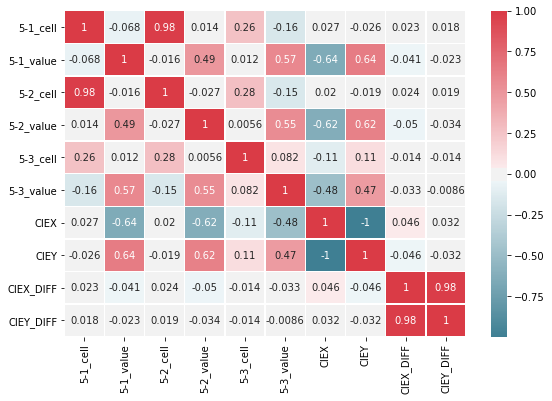

In [7]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = plt.subplots(figsize=(9, 6))
sns.heatmap(train_df[FeatureIndex+TargetIndex].corr(),annot=True,cmap = cmap , linewidths=.5)
plt.savefig("HtMap.jpg")

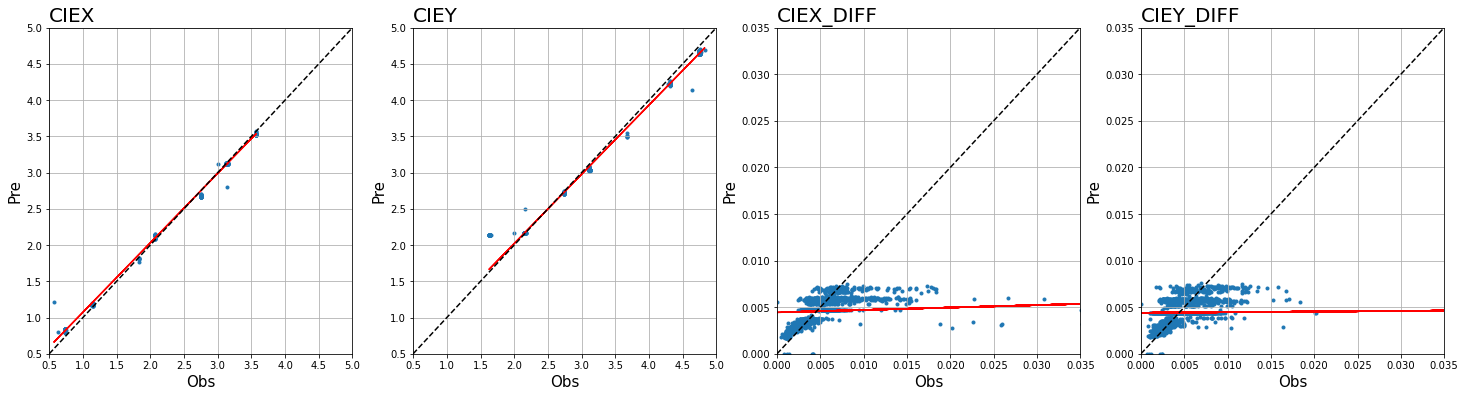

In [40]:
from sklearn.metrics import r2_score
plt.figure(figsize=(25,6))
for n in range(2):
    plt.subplot(1,4,n+1)
    plt.scatter(test_feature[TargetIndex[n]],Pre_df[n],marker = ".")
    plt.title(test_feature.columns[n],loc='left',fontsize=20)
    plt.xlabel("Obs",fontsize=15)
    plt.ylabel("Pre",fontsize=15)
    plt.ylim(0.5,5)
    plt.xlim(0.5,5)
    z = np.polyfit(pd.to_numeric(test_feature[TargetIndex[n]]), pd.to_numeric(Pre_df[n]), 1)
    p = np.poly1d(z) 
    plt.plot(test_feature[TargetIndex[n]],p(test_feature[TargetIndex[n]]),"r")
    plt.grid()
    plt.plot([0.5, 5], [0.5, 5],ls='--',c="0")
for n in range(2,4,1):
    plt.subplot(1,4,n+1)
    plt.scatter(test_feature[TargetIndex[n]],Pre_df[n],marker = ".")
    plt.title(test_feature.columns[n],loc='left',fontsize=20)
    plt.xlabel("Obs",fontsize=15)
    plt.ylabel("Pre",fontsize=15)
    plt.ylim(0,0.035)
    plt.xlim(0,0.035)
    z = np.polyfit(pd.to_numeric(test_feature[TargetIndex[n]]), pd.to_numeric(Pre_df[n]), 1)
    p = np.poly1d(z) 
    plt.plot(test_feature[TargetIndex[n]],p(test_feature[TargetIndex[n]]),"r")
    plt.grid()
    plt.plot([0, 0.035], [0, 0.035],ls='--',c="0")
plt.savefig('MultyMAE.jpg',bbox_inches='tight')